In [1]:
import sys

sys.path.append("..")

In [2]:
import os
from typing import Tuple
import math

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torchvision.datasets
import torch.utils.data
import torchvision.transforms.functional as F

from PIL import Image

import transforms
import visualize
import datasets

from brain_segmentation_pytorch.unet import UNet

/home/akors/.conda/envs/ml/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/akors/.conda/envs/ml/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you

## Dataset setup

### Transforms

In [3]:
tr_inf = transforms.make_transforms(datasets.DATASET_STATS["2012"]["rgb_mean"], datasets.DATASET_STATS["2012"]["rgb_std"])
tr_img_inv = transforms.inv_normalize(datasets.DATASET_STATS["2012"]["rgb_mean"], datasets.DATASET_STATS["2012"]["rgb_std"])

In [4]:
datasets.DATASET_STATS["2012"]["rgb_mean"], datasets.DATASET_STATS["2012"]["rgb_std"]

([0.456797805118573, 0.4431319283728635, 0.4082984168812775],
 [0.27287834297763963, 0.2693239723248675, 0.28497994197739135])

### Dataset loading

In [5]:
dataroot = '../data/'

In [6]:
ds_train = torchvision.datasets.wrap_dataset_for_transforms_v2(torchvision.datasets.VOCSegmentation(
    root=dataroot,
    year="2012",
    image_set="train",
    download=False,
    transforms=tr_inf))


In [7]:
ds_val = torchvision.datasets.wrap_dataset_for_transforms_v2(torchvision.datasets.VOCSegmentation(
    root=dataroot,
    year="2012",
    image_set="val",
    download=False,
    transforms=tr_inf))

In [8]:
len(ds_train)

1464

In [9]:
img, mask = ds_train[2]

In [10]:
img.shape

torch.Size([3, 256, 256])

In [11]:
img.device

device(type='cpu')

In [12]:
mask.shape

torch.Size([1, 256, 256])

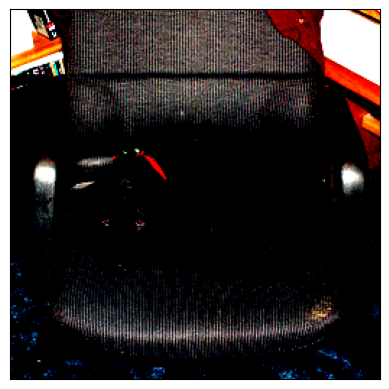

In [13]:
plt.figure()
visualize.imshow_tensor(img, ax=plt.gca())
plt.show()

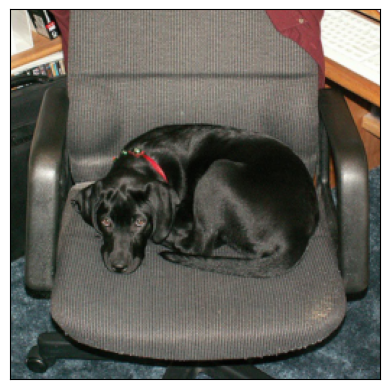

In [14]:
plt.figure()
visualize.imshow_tensor(tr_img_inv(img), ax=plt.gca())
plt.show()

## Load Model

In [15]:
# Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
# Model from checkpoint file
def model_from_checkpoint(checkpointfile):
    checkpoint = torch.load(checkpointfile)
    unet_features = checkpoint['model_state_dict']['encoder1.enc1conv1.weight'].size(0)
    model = UNet(
        in_channels=3,
        out_channels=datasets.CLASS_MAX+1,
        init_features=unet_features,
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.eval().to(device)
    return model

In [17]:
#model = model_from_checkpoint("../checkpoints/test.chpt.pt")
model = model_from_checkpoint("../checkpoints/dogunet_f64_ce_aug2_lr1e-4.chpt1000.pt")

## Predictions

In [18]:
def topclass_dict(mask: torch.Tensor, k: int=4):
    pred_classes, counts = mask.unique(return_counts=True)
    topcounts, topcounts_idx = torch.topk(counts, min(k, len(counts)))
    #topclasses = pred_classes[topcounts_idx]

    top_k_classpixels = {
        datasets.CLASSNAMES[pred_classes[i].item()] : counts[i].item()
        for i in topcounts_idx
    }

    return top_k_classpixels

In [19]:
def infer_ds_sample(sample: Tuple[torch.Tensor, torch.Tensor], model=model, fig=None):
    # get current figure if it was not provided
    fig = fig if fig else plt.gcf()

    # take out sample, add singleton batch dimension
    img, mask = sample
    img = img.unsqueeze(0)
    mask = mask[0,:].unsqueeze(0)

    # do prediction
    with torch.no_grad():
        pred = model(img.to(device))
        pred = pred.to(device='cpu')
        pred_amax = torch.argmax(pred, dim=1)
        
    # get all unique classes in prediction
    show_classes = set((t.item() for t in pred_amax[0,:].unique()))
    # add all unique classes in mask
    show_classes.union((t.item() for t in mask[0,:].unique()))
    
    _, axs = visualize.plot_prediction_comparison(img=tr_img_inv(img[0,:]), prediction_mask=pred_amax[0,:], target_mask=mask[0,:], fig=fig)
    visualize.make_colormap_legend(ax=plt.gca(), fig=fig, cmap=visualize.cm_tab21, class_names=datasets.CLASSNAMES.values(), only_classes=show_classes)

    top_k_classpixels = topclass_dict(pred_amax)

    return fig, top_k_classpixels


In [20]:
sample = ds_train[2]

### Training Set

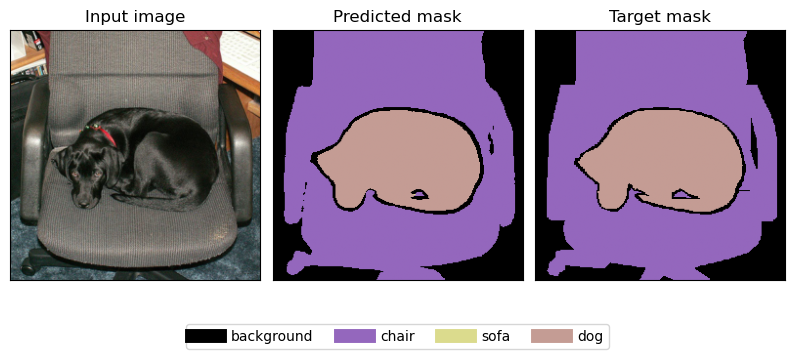

In [21]:
plt.figure(figsize=(10,4))
infer_ds_sample(ds_train[2], model=model)
plt.show()

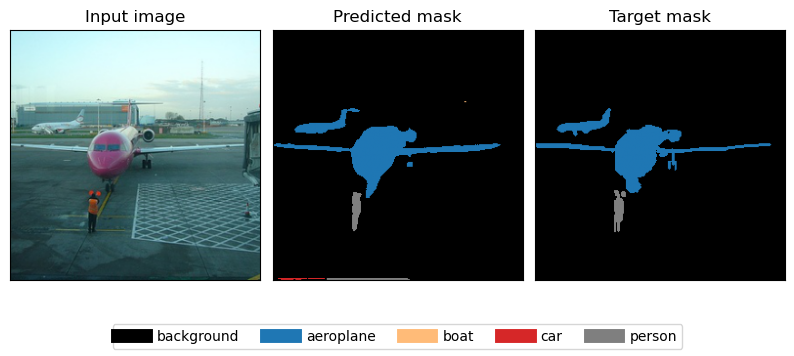

In [22]:
plt.figure(figsize=(10,4))
infer_ds_sample(ds_train[0], model=model)
plt.show()

### Validation Set

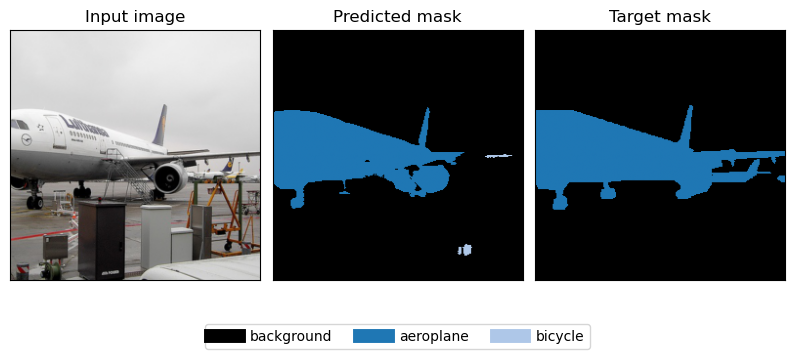

In [23]:
plt.figure(figsize=(10,4))
infer_ds_sample(ds_val[0], model=model)
plt.show()

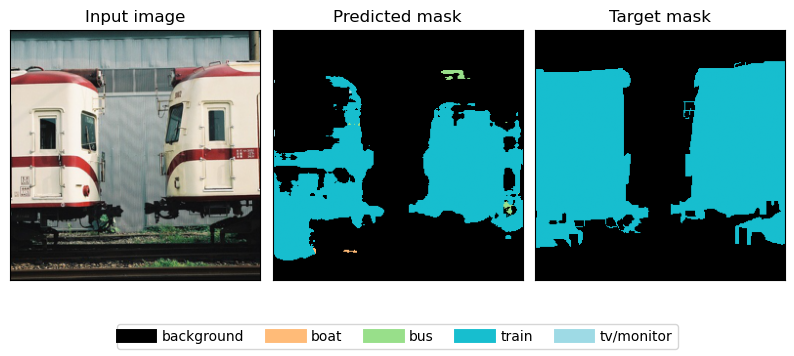

In [24]:
plt.figure(figsize=(10,4))
infer_ds_sample(ds_val[1], model=model)
plt.show()

### Custom Input

In [25]:
def infer_imgfile(path: str, model=model, fig=None):
    # get current figure if it was not provided
    fig = fig if fig else plt.gcf()

    with Image.open(path) as imgfile:
        img = tr_inf(imgfile)

    with torch.no_grad():    
        pred = model(img.unsqueeze(0).to(device))
        pred = pred.to(device='cpu')
        pred_amax = torch.argmax(pred.squeeze(0), dim=0)
        
    # get all unique classes in prediction
    show_classes = set((t.item() for t in pred_amax.unique()))
    
    _, axs = visualize.plot_prediction_comparison(
        img=tr_img_inv(img),
        prediction_mask=pred_amax,
        fig=fig
    )
    visualize.make_colormap_legend(
        ax=plt.gca(), fig=fig,
        cmap=visualize.cm_tab21,
        class_names=datasets.CLASSNAMES.values(),
        only_classes=show_classes
    )


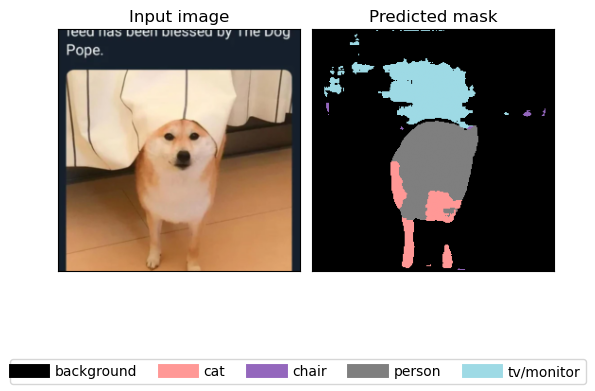

In [26]:
infer_imgfile("../samples/dogpope.jpg", model=model)

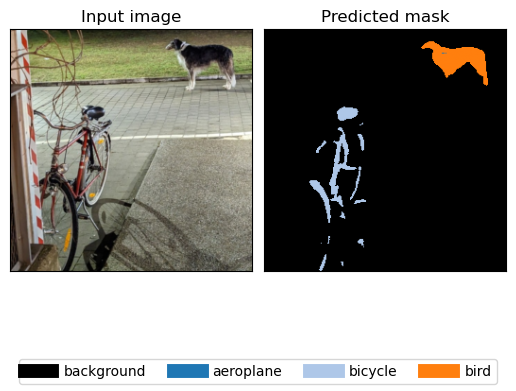

In [27]:
infer_imgfile("../samples/ghost1_cropped.jpg", model=model)

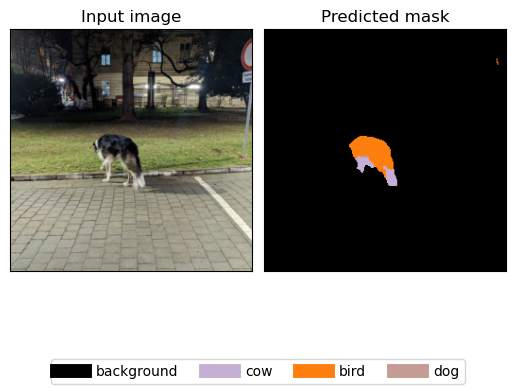

In [28]:
infer_imgfile("../samples/ghost2.jpg", model=model)

### Multiple File input

In [29]:
def infer_and_plot_files(imgfiles, model=model):
    figheight = 4 *len(imgfiles)
    fig = plt.figure(figsize=(8, figheight))
    figs = fig.subfigures(nrows=len(imgfiles))
    for img_idx, imgfile in enumerate(imgfiles):
        infer_imgfile(imgfile, fig=figs[img_idx], model=model)
        figs[img_idx].suptitle(os.path.splitext(os.path.basename(imgfile))[0])

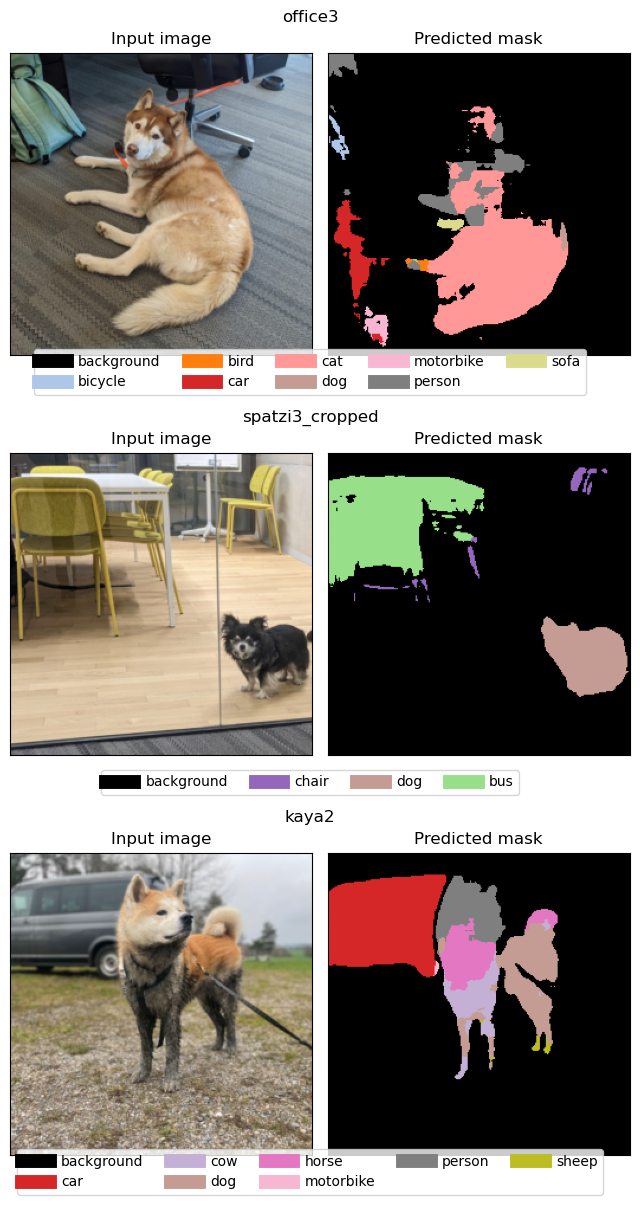

In [30]:
imgfiles = ["../samples/office3.jpg", "../samples/spatzi3_cropped.jpg", "../samples/kaya2.jpeg"]
infer_and_plot_files(imgfiles, model=model)

## Heat Maps

In [31]:
def plot_class_heatmap(img, pred, fig=None, limit_classes=[], show_orig=True):
    fig =  plt.gcf() if fig is None else fig


    with torch.no_grad():
        pred_amax = torch.argmax(pred, dim=0)
        pred_unique_classes = pred_amax.unique()

    ncols = min(3, len(pred_unique_classes) + bool(show_orig))
    nrows = math.ceil((len(pred_unique_classes) + bool(show_orig)) / ncols)
    axs = fig.subplots(nrows=nrows, ncols=ncols)
    axs_raveled = np.ravel(axs)
    if show_orig:
        ax = axs_raveled[0]
        ax.set_title("Original")
        visualize.imshow_tensor(tr_img_inv(img), ax=ax)

    unique_class_gen = (u.item() for u in pred_unique_classes if u in limit_classes or len(limit_classes)==0)
    for idx, unique_class in enumerate(unique_class_gen, start=bool(show_orig)):
        ax = axs_raveled[idx]
        ax.imshow(pred[unique_class,:,:].numpy(), vmin=0.0, vmax=1.0, cmap='inferno')

        ax.set_title(datasets.CLASSNAMES[unique_class])

    for ax in axs_raveled:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

    fig.subplots_adjust(wspace=0.1, hspace=0)

    return fig, axs

In [32]:
img = ds_train[2][0]

In [33]:
with torch.no_grad():    
    pred = model(img.unsqueeze(0).to(device))
    pred = pred.to(device='cpu')

/tmp/ipykernel_8037/2024737344.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


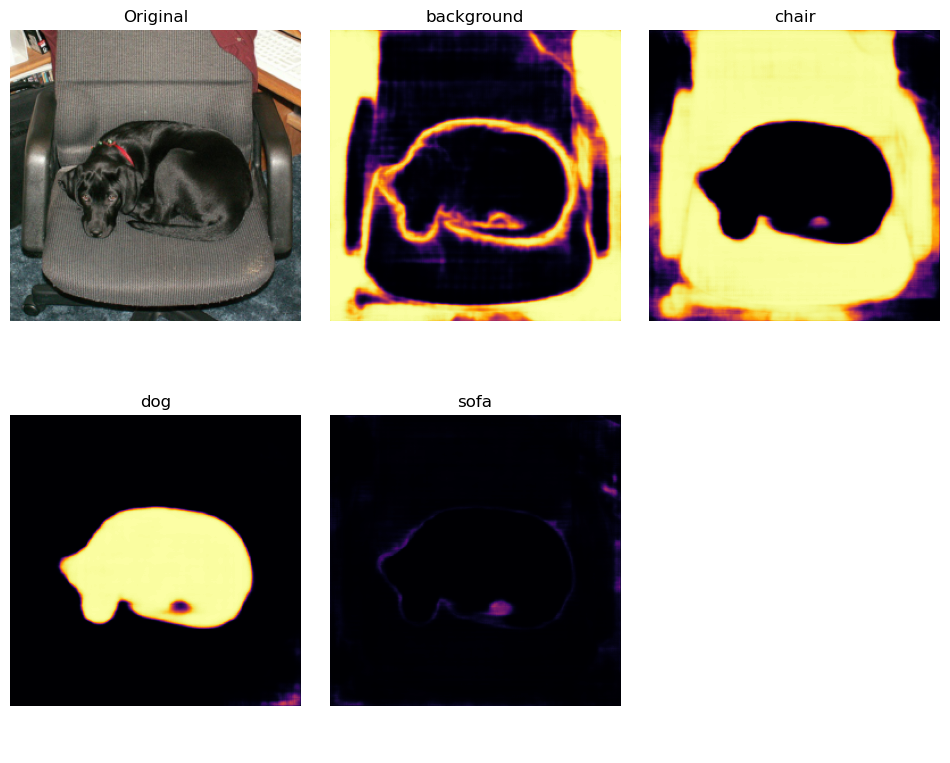

In [34]:
fig = plt.figure(figsize=(12,4))
_, axs = plot_class_heatmap(img, pred=pred[0,:], fig=fig)
fig.set_figheight(5*len(axs))
fig.show()


In [35]:
def makefig_class_heatmaps(img, model=model):
    with torch.no_grad():    
        pred = model(img.unsqueeze(0).to(device))
        pred = pred.to(device='cpu')

    fig = plt.figure(figsize=(12,4))
    _, axs = plot_class_heatmap(img, pred=pred[0,:], fig=fig)

    fig.set_figheight(5*len(axs))

    return fig, axs


(<Figure size 1200x1000 with 6 Axes>,
 array([[<Axes: title={'center': 'Original'}>,
         <Axes: title={'center': 'background'}>,
         <Axes: title={'center': 'boat'}>],
        [<Axes: title={'center': 'bus'}>,
         <Axes: title={'center': 'train'}>,
         <Axes: title={'center': 'tv/monitor'}>]], dtype=object))

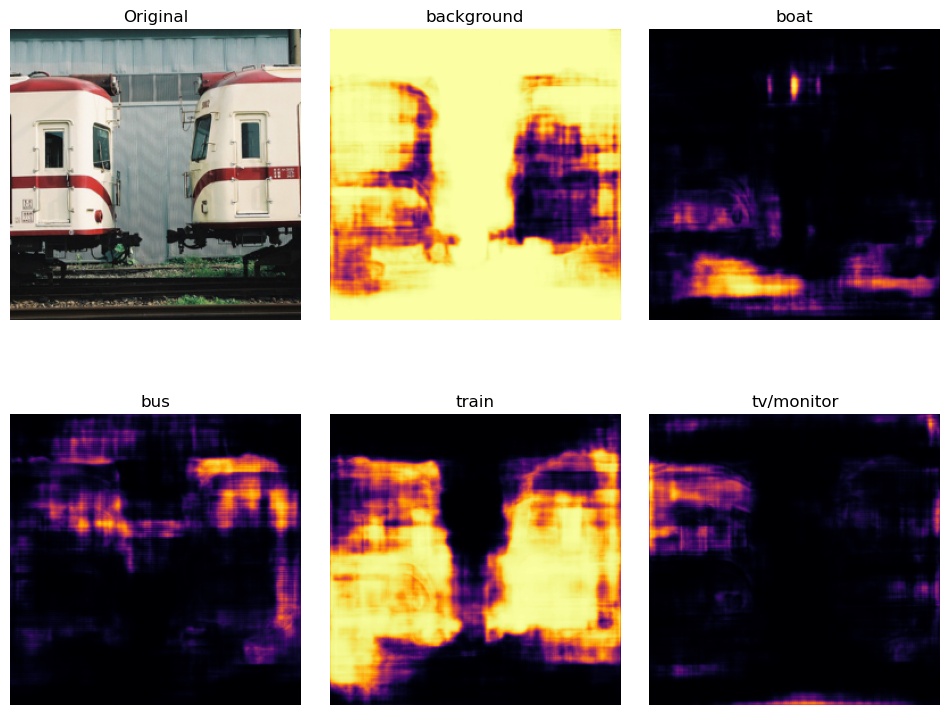

In [36]:
makefig_class_heatmaps(ds_val[1][0])

In [37]:
def makefig_class_heatmaps_fromfile(imgfile, model=model):
    with Image.open(imgfile) as imgfile:
        img = tr_inf(imgfile)

    return makefig_class_heatmaps(img=img, model=model)

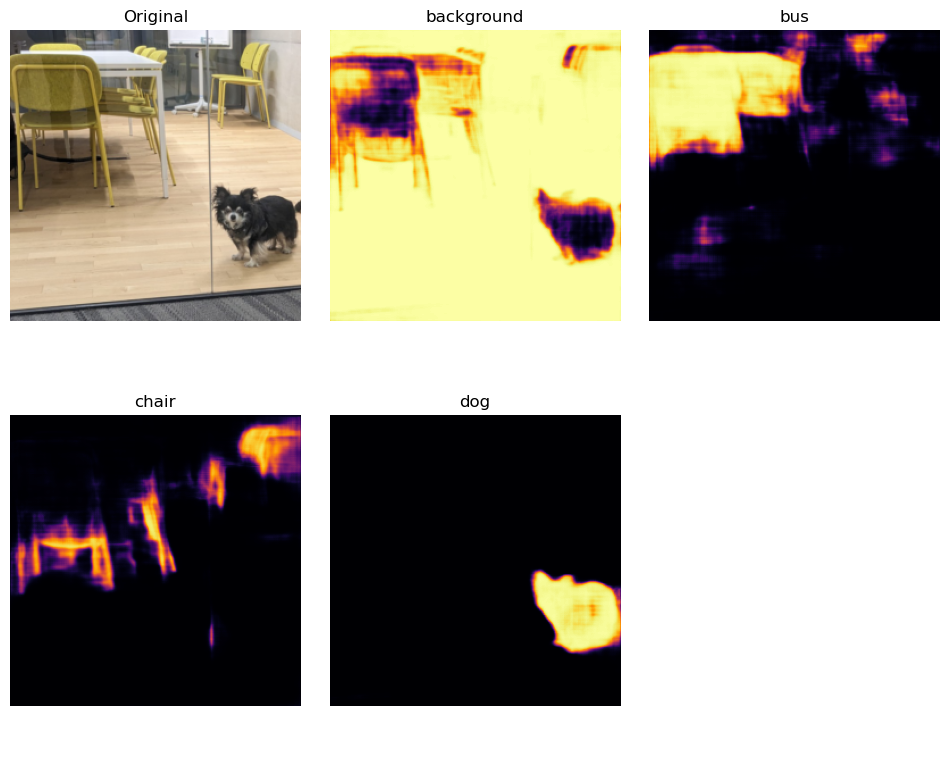

In [38]:
imgfile = "../samples/spatzi3_cropped.jpg"
makefig_class_heatmaps_fromfile(imgfile, model=model);

## Class Masks

In [39]:
img = ds_train[2][0]

In [40]:
with torch.no_grad():    
    pred = model(img.unsqueeze(0).to(device))
    pred = pred.to(device='cpu')

In [41]:
masked_img = torch.cat((tr_img_inv(img), pred[0,12,:,:].unsqueeze(0)))

In [42]:
masked_img.shape

torch.Size([4, 256, 256])

In [43]:
masked_img[3,:].max()

tensor(0.9992)

2023-05-21 12:46:17,855 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


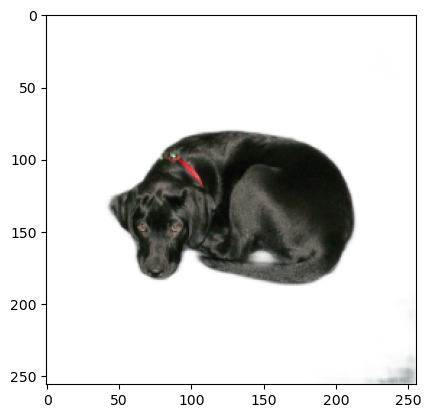

In [44]:
plt.imshow(masked_img.permute(1, 2, 0).numpy())

In [45]:
def plot_img_classmasked(img, pred, fig=None, limit_classes=[], show_orig=True):
    fig =  plt.gcf() if fig is None else fig

    with torch.no_grad():
        pred_amax = torch.argmax(pred, dim=1)
        pred_unique_classes = pred_amax.unique()

    denormalized_img = tr_img_inv(img)

    ncols = min(3, len(pred_unique_classes) + bool(show_orig))
    nrows = math.ceil((len(pred_unique_classes) + bool(show_orig)) / ncols)
    axs = fig.subplots(nrows=nrows, ncols=ncols)
    axs_raveled = np.ravel(axs)
    if show_orig:
        ax = axs_raveled[0]
        ax.set_title("Original")
        visualize.imshow_tensor(denormalized_img, ax=ax)
    
    # disable xticks, yticks, and axis. The axis will be re-enabled for subplots with content in them.
    for ax in axs_raveled:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

    unique_class_gen = (u.item() for u in pred_unique_classes if u in limit_classes or len(limit_classes)==0)
    for idx, unique_class in enumerate(unique_class_gen, start=bool(show_orig)):
        ax = axs_raveled[idx]

        # We will abuse the sigmoid model output of this class as the alpha channel
        # probs are between 0 and 1, alpha should be between 0 and 255
        channelmask =  pred[0,unique_class,:,:].unsqueeze(0)# * 256.0

        # stack RGB data with output probablity as alpha
        masked_img = torch.cat(dim=0, tensors=(denormalized_img, channelmask))

        # numpy the torch
        masked_img = masked_img.permute(1, 2, 0).numpy()

        ax.imshow(masked_img)
        ax.set_title(datasets.CLASSNAMES[unique_class])
        ax.axis('on')

    
    fig.subplots_adjust(wspace=0, hspace=.2)

    return fig, axs

In [46]:
img = ds_train[2][0]

In [47]:
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))
    pred = pred.to(device='cpu')
    pred_amax = torch.argmax(pred, dim=1)

2023-05-21 12:46:18,301 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-05-21 12:46:18,305 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-05-21 12:46:18,310 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-05-21 12:46:18,313 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


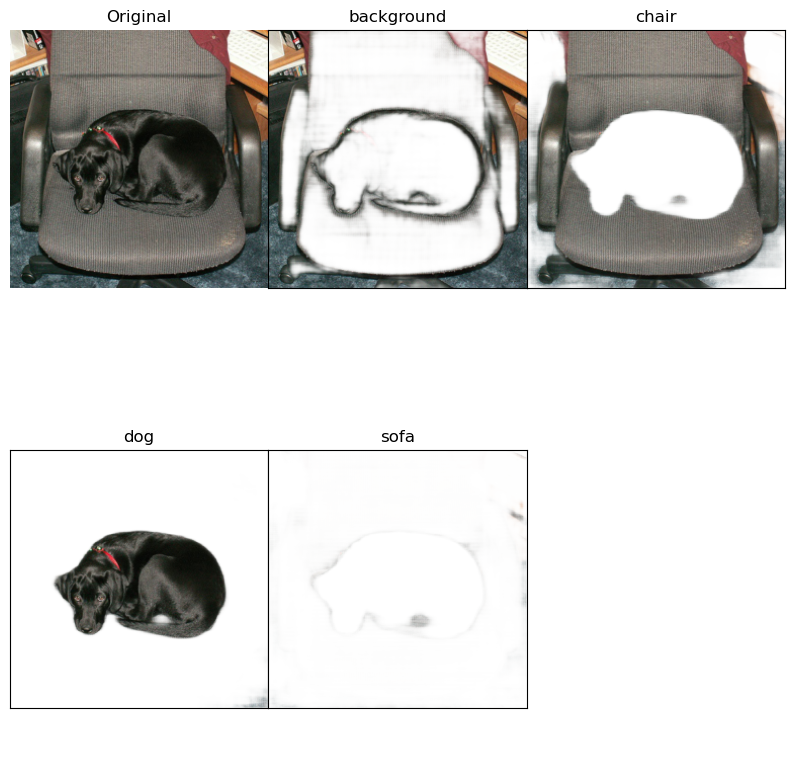

In [48]:
fig = plt.figure(figsize=(10,10))
plot_img_classmasked(img, pred, fig=fig);

In [49]:
def makefig_img_classmasked(img, model=model, fig=None):
    # get current figure if it was not provided
    fig = fig if fig else plt.gcf()


    with torch.no_grad():    
        pred = model(img.unsqueeze(0).to(device))
        pred = pred.to(device='cpu')
    
    _, axs = plot_img_classmasked(img, pred, fig=fig)
    return fig, axs
    

2023-05-21 12:46:18,861 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-05-21 12:46:18,865 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-05-21 12:46:18,868 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-05-21 12:46:18,871 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-05-21 12:46:18,873 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


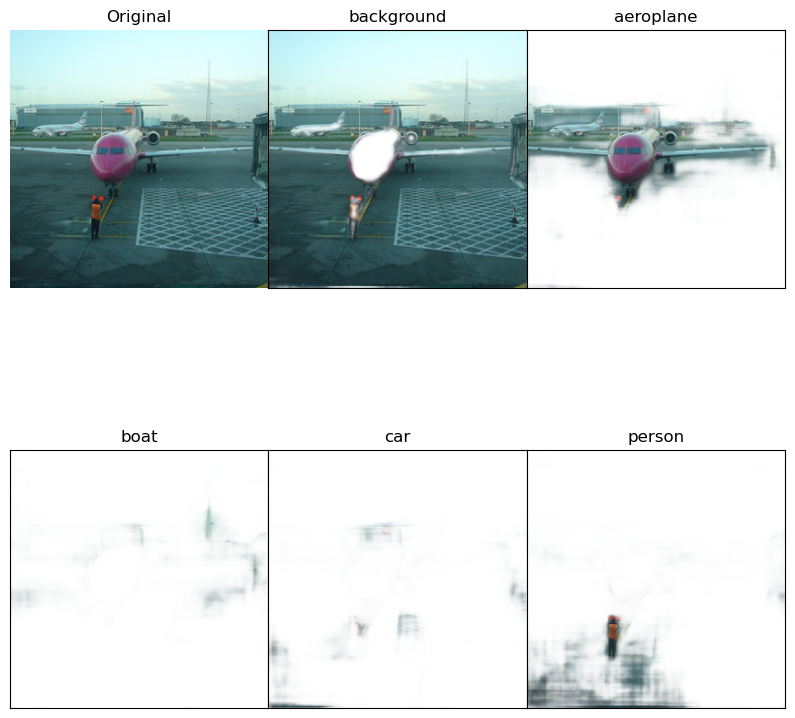

In [50]:
fig = plt.figure(figsize=(10,10))
makefig_img_classmasked(ds_train[0][0]);

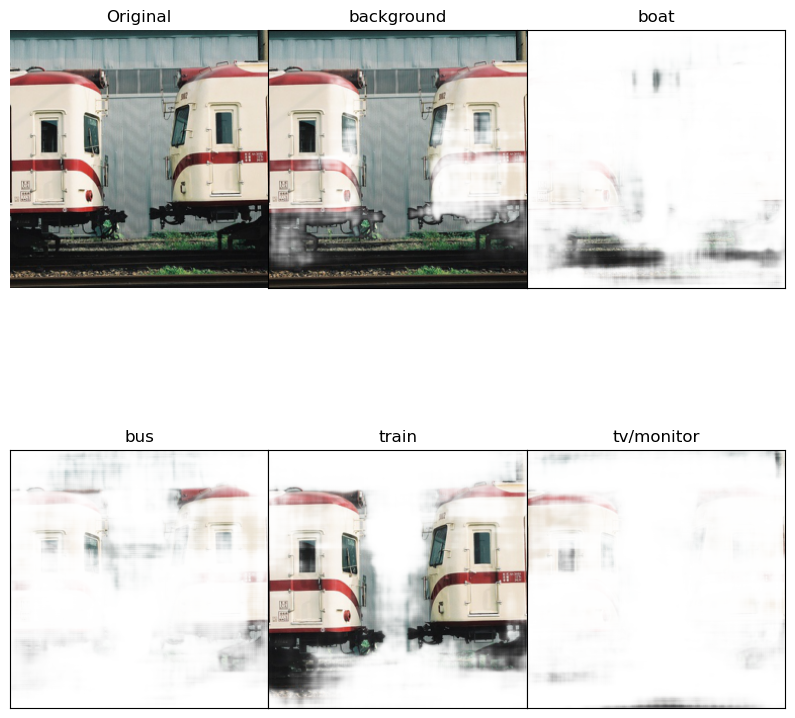

In [51]:
fig = plt.figure(figsize=(10,10))
makefig_img_classmasked(ds_val[1][0]);

In [52]:
def makefig_img_classmasked_fromfile(imgfile, model=model, fig=None):
    with Image.open(imgfile) as imgfile:
        img = tr_inf(imgfile)

    return makefig_img_classmasked(img=img, model=model, fig=fig)

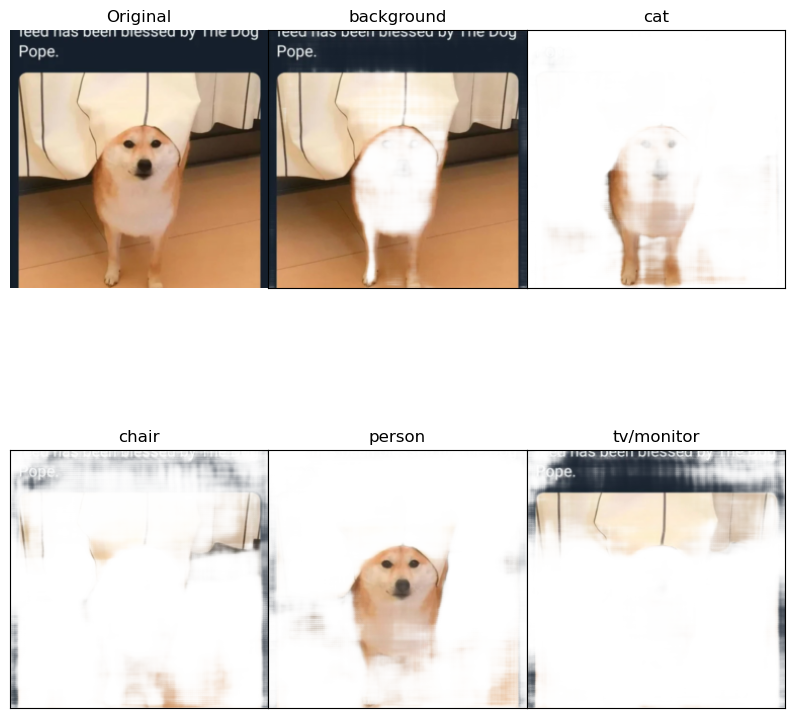

In [53]:
imgfile = "../samples/dogpope.jpg"
fig = plt.figure(figsize=(10,10))
makefig_img_classmasked_fromfile(imgfile, model=model);

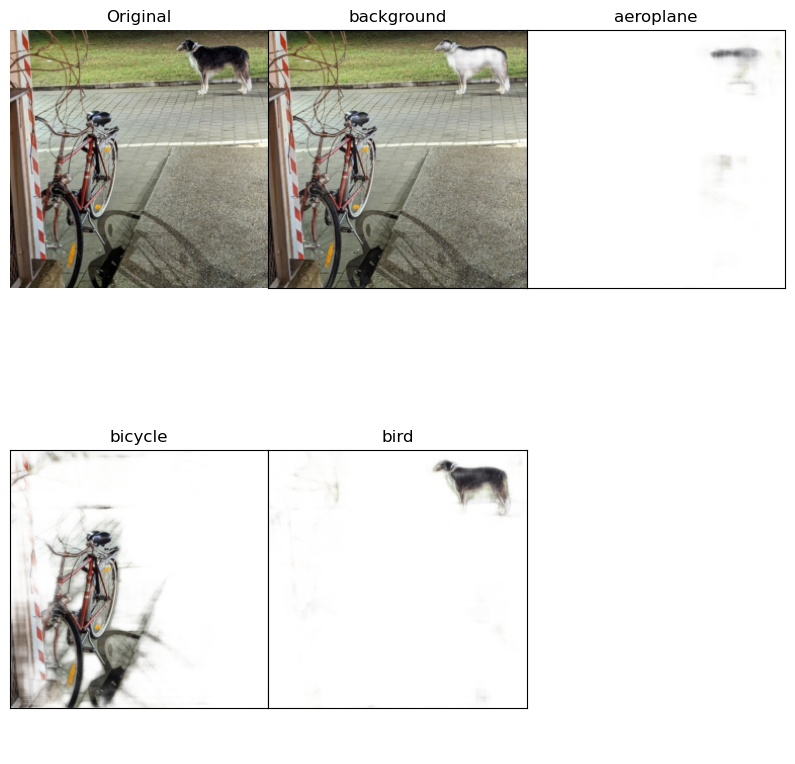

In [54]:
imgfile = "../samples/ghost1_cropped.jpg"
fig = plt.figure(figsize=(10,10))
makefig_img_classmasked_fromfile(imgfile, model=model, fig=fig);

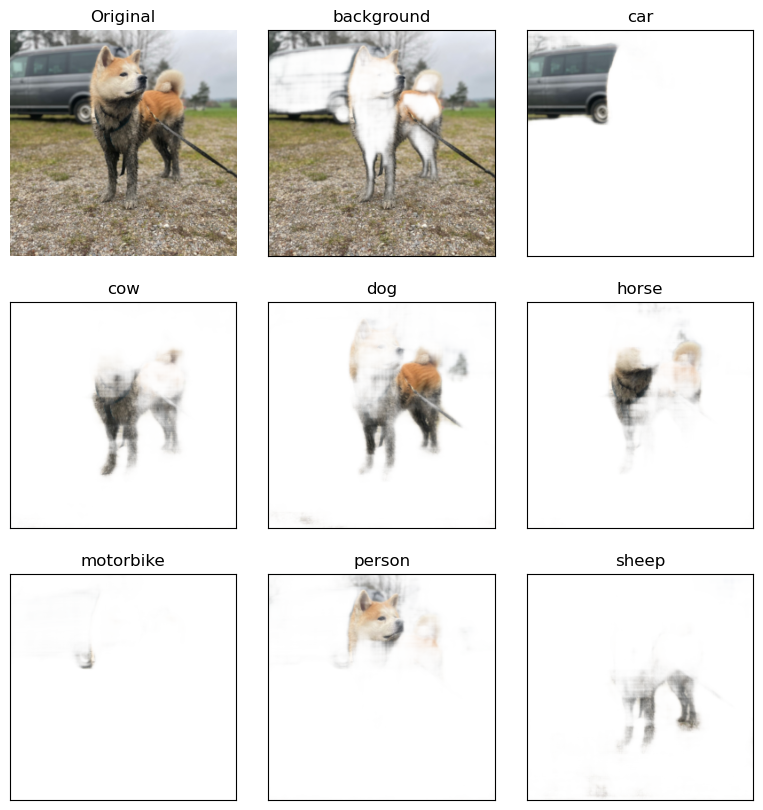

In [55]:
imgfile = "../samples/kaya2.jpeg"
fig = plt.figure(figsize=(10,10))
makefig_img_classmasked_fromfile(imgfile, model=model, fig=fig);